<a href="https://colab.research.google.com/github/jha-vineet69/Car-Damage-Detection/blob/main/Car_Damage_Detection_Step_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import Libraries

import os
import glob
import datetime
import numpy as np
import h5py
import json
import pickle
import time
import urllib.request

# keras imports
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model

# imports required packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# other imports
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Create a dictionary with configuration/setup we will be using

config={
  "model"           : "vgg16",
  "weights"         : "imagenet",
  "include_top"     : False,

  "train_path"      : "/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/data3a/training",
  "test_path"       : "/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/data3a/validation",
  "features_path"   : "/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/features3.h5",
  "labels_path"     : "/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/labels3.h5",
  "classifier_path" : "/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/classifier3.pickle",
  "model_path"      : "/content/drive/MyDrive/Colab Notebooks/Minor Project Sem 7/model3",

  "test_size"       : 0.20,
  "seed"            : 9,
}

In [ ]:
# config variables
model_name    = config["model"]
weights     = config["weights"]
train_path    = config["train_path"]
features_path   = config["features_path"]
labels_path   = config["labels_path"]
test_size     = config["test_size"]
model_path    = config["model_path"]
classifier_path = config["classifier_path"]
seed      = config["seed"]

In [ ]:
# Here we are loading the base VGG16 model with weights and then excluding the top dense layer
if model_name == "vgg16":
    base_model = VGG16(weights=weights)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
    image_size = (224, 224)
else:
    base_model = None

print ("Successfully loaded base model and model...")

553467904/553467096 [==============================] - 4s 0us/step
Successfully loaded base model and model...


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# path to training dataset
train_labels = os.listdir(train_path)

# encode the labels
print ("Encoding labels...")
le = LabelEncoder()
le.fit([tl for tl in train_labels])

# variables to hold features and labels
features = []
labels   = []

# loop over all the labels in the folder
count = 1
for i, label in enumerate(train_labels):
    cur_path = train_path + "/" + label
    count = 1
    for image_path in glob.glob(cur_path + "/*.jpg"):
        img = image.load_img(image_path, target_size=image_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = model.predict(x)
        flat = feature.flatten()
        features.append(flat)
        labels.append(label)
        count += 1
    print ("Completed label - " + label)

# encode the labels using LabelEncoder
le = LabelEncoder()
le_labels = le.fit_transform(labels)

# get the shape of training labels
# print ("[STATUS] training labels: {}".format(le_labels))
print ("[STATUS] training labels shape: {}".format(le_labels.shape))

Encoding labels...
Completed label - minor
Completed label - moderate
Completed label - severe
[STATUS] training labels shape: (979,)


In [ ]:
# save features and labels
h5f_data = h5py.File(features_path, 'w')
h5f_data.create_dataset('dataset_2', data=np.array(features))

h5f_label = h5py.File(labels_path, 'w')
h5f_label.create_dataset('dataset_2', data=np.array(le_labels))

h5f_data.close()
h5f_label.close()

# save model and weights
model_json = model.to_json()
with open(model_path + str(test_size) + ".json", "w") as json_file:
    json_file.write(model_json)

# save weights
model.save_weights(model_path + str(test_size) + ".h5")
print("Saved model and weights to disk..")

print ("Features and labels saved..")

Saved model and weights to disk..
Features and labels saved..


In [ ]:
# import features and labels
h5f_data  = h5py.File(features_path, 'r')
h5f_label = h5py.File(labels_path, 'r')

features_string = h5f_data['dataset_2']
labels_string   = h5f_label['dataset_2']

features = np.array(features_string)
labels   = np.array(labels_string)

h5f_data.close()
h5f_label.close()

In [ ]:
# verify the shape of features and labels
print ("[INFO] features shape: {}".format(features.shape))
print ("[INFO] labels shape: {}".format(labels.shape))

print ("[INFO] training started...")
# split the training and testing data
(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(features),
                                                                  np.array(labels),
                                                                  test_size=test_size,
                                                                  random_state=seed)

print ("[INFO] splitted train and test data...")
print ("[INFO] train data  : {}".format(trainData.shape))
print ("[INFO] test data   : {}".format(testData.shape))
print ("[INFO] train labels: {}".format(trainLabels.shape))
print ("[INFO] test labels : {}".format(testLabels.shape))

[INFO] features shape: (979, 4096)
[INFO] labels shape: (979,)
[INFO] training started...
[INFO] splitted train and test data...
[INFO] train data  : (783, 4096)
[INFO] test data   : (196, 4096)
[INFO] train labels: (783,)
[INFO] test labels : (196,)


In [ ]:
# use logistic regression as the model
print ("[INFO] creating model...")
model = LogisticRegression(random_state=seed)
model.fit(trainData, trainLabels)

[INFO] creating model...


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=9, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# evaluate the model of test data
preds = model.predict(testData)

In [ ]:
preds.shape

(196,)

In [ ]:
# dump classifier to file
print ("[INFO] saving model...")
pickle.dump(model, open(classifier_path, 'wb'))

[INFO] saving model...


In [ ]:
# plot the confusion matrix
cm = confusion_matrix(testLabels, preds)
cm

array([[30, 18,  2],
       [11, 39, 10],
       [ 3, 11, 72]])

In [ ]:
accuracy_score(testLabels, preds)

0.7193877551020408

In [ ]:
label_check1 = ['Minor', 'Moderate', 'Severe']

In [ ]:
print(classification_report(testLabels, preds, target_names=label_check1))

              precision    recall  f1-score   support

       Minor       0.68      0.60      0.64        50
    Moderate       0.57      0.65      0.61        60
      Severe       0.86      0.84      0.85        86

    accuracy                           0.72       196
   macro avg       0.70      0.70      0.70       196
weighted avg       0.73      0.72      0.72       196



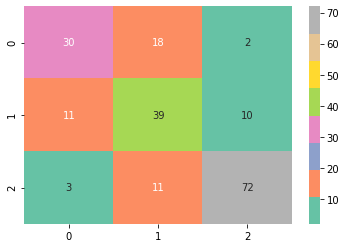

In [ ]:
sns.heatmap(cm, annot=True, cmap="Set2")
plt.show()

In [ ]:
# load the trained logistic regression classifier
print ("[INFO] loading the classifier...")
classifier = pickle.load(open(config["classifier_path"], 'rb'))

# pretrained models needed to perform feature extraction on test data too!
if config["model"] == "vgg16":
	base_model = VGG16(weights=config["weights"])
	model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
	image_size = (224, 224)

else:
	base_model = None

[INFO] loading the classifier...


In [ ]:
def pipe4(image_path, model, classifier):
    urllib.request.urlretrieve(image_path, 'image.jpg')
    img = image.load_img('image.jpg', target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)
    flat = feature.flatten()
    flat = np.expand_dims(flat, axis=0)
    preds = classifier.predict(flat)
    print("Finding the severity of damage....")
    print(f"Validation complete - The car damage is {label_check1[preds[0]]}.")   

In [ ]:
pipe4('https://tse4.mm.bing.net/th?id=OIP.LlCtLGvdxEtMaRyAWsn_zAAAAA', model, classifier)

Finding the severity of damage....
Validation complete - The car damage is Severe.


In [ ]:
pipe4('http://www.readthehook.com/files/imagecache/max_viewable/images/field_images/news-runawaycar-mazda-rear.jpg', model, classifier)

Finding the severity of damage....
Validation complete - The car damage is Severe.


In [ ]:
pipe4('https://www.side.cr/wp-content/uploads/2018/09/Connecticut-Sell-Damaged-Car.jpg', model, classifier)

Finding the severity of damage....
Validation complete - The car damage is Moderate.
